<a href="https://colab.research.google.com/github/Tyrannozavr/machine_learning/blob/master/save_result_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
!git clone https://github.com/CipiOrhei/TMBuD

Cloning into 'TMBuD'...
remote: Enumerating objects: 2504, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (752/752), done.
remote: Total 2504 (delta 53), reused 789 (delta 46), pack-reused 1706
Receiving objects: 100% (2504/2504), 1.86 GiB | 49.45 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Updating files: 100% (1585/1585), done.


In [2]:
from skimage.transform import resize
import pandas
import os
import torch
import cv2
# from google.colab.patches import cv2_imshow
from skimage.io import imread
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
root = 'TMBuD/'
images_dir = root + 'images/'
lesions_dir = root + 'gt_label/'
dataset_csv = root + 'DATASET SPLIT.csv'

Ну я сразу скажу, что здесь вроде как предусмотрен какой то файл для более простой загрузки датасета, наверное, я сильно не разбирался, установил зависимости, он выдал мне какую то непонятную ошибку и я решил, что мне проще просто использовать эти картинки и не мучить голову свою

In [4]:
table = pandas.read_csv(dataset_csv)

In [5]:
table.head()

,Picture Name,Building Name,Coordinates Landmark,Coordinates image,GT salient edges,GT labels,Condition,Quality,Dataset STANDARD,Dataset 3_2,Dataset 3_5_NIGHT,Dataset 3_N,SEMSEG_EVAL_FULL,END
0,1,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75174775294593; 21.22478407583839,Done,Done,NIGHT,GOOD,TRAIN,None,TEST,TEST,TRAIN,'
1,2,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751577081296176; 21.22472497882864,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TRAIN,'
2,3,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TEST,'
3,4,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,VAL,TEST,TEST,TEST,TRAIN,'
4,5,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751259791003264; 21.224710204576198,Done,Done,DAY,GOOD,TEST,None,None,None,TRAIN,'


Так, ну для начала я понял, что смысла в этой таблице для меня особо нет т.к. здесь куча данных, но то, что мне нужно (например количество окон) отсутствует, как и адрес изображения, не знаю какой смысл мне в этой цифре, мол, вот 1 изображение. Была бы польза от полного имени

In [6]:
def get_name(numb):
    if len(str(numb)) == 1:
        return f'0000{numb}.png'
    if len(str(numb)) == 2:
        return f'000{numb}.png'
    if len(str(numb)) == 3:
        return f'00{numb}.png'
    if len(str(numb)) == 4:
        return f'0{numb}.png'
    if len(str(numb)) == 5:
        return f'{numb}.png'

In [7]:
images = []
lesions = []
size = (256, 256)

for i in range(1, 7):
  img = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  images.append(img)
  img = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  lesions.append(img)

Дело в том, что для решения задачи сегментации мне понадобится метка здания, а для решения задачи регрессии, я думаю, мне понадобятся отмеченные окна, вот их метки я и буду подавать на регрессионную модель, возможно лучше даже обучить 2 разные модели, пока думаю над этим

In [11]:
background =    (0,     0,      0)
sky =           (255,   0,      0)
vegetation =    (0,     255,    0)
building =      (125,   125,    0)
window =        (0,     255,    255)
ground =        (125,   125,    125)
noise =         (0,     0,      255)
door =          (0,     125,    125)

background = np.array((0, 0, 0), dtype=np.uint8)

Нужно оптимизировать этот алгоритм, бо это ужас, к сожалению не удалось сделать красиво одним срезом, похоже так только каждый элемент можно перебрать, ну или я не полностью знаю возможности numpy

Я все таки решил, что надеждней обучить 2 модели, одна будет рисовать фасад здания, другая делать сегментацию окон, дальше эти окна (ну, маску) либо на регрессию, либо даже что то попроще, просто сосчитат пространства зарисованные

Сейчас я попробую при помощи этой функции создать датасет для сегментации окон

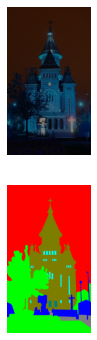

In [59]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(1):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(ds_wind[i])
plt.show();

Следующий цикл проходит по сегментированным изображениям и всего лишь удаляет все, кроме окон

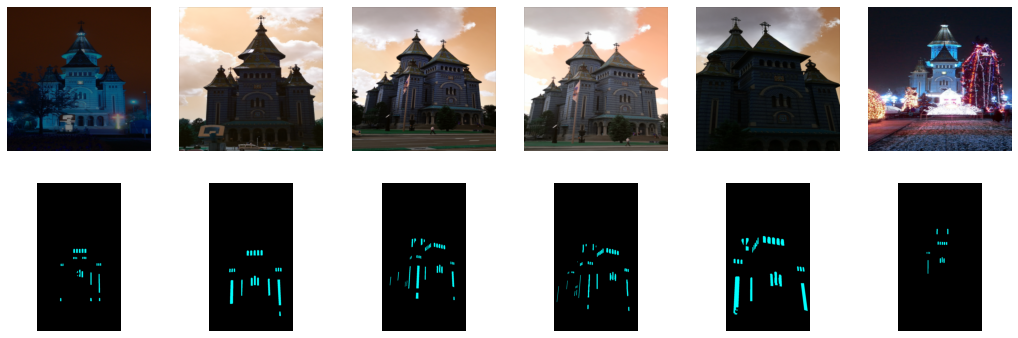

In [74]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
df_windows = []
for image in lesions:
  image = image.copy()
  for idx_row, row in enumerate(image):
    for idx_col, cell in enumerate(row):
      if any(cell != [0, 255, 255]):
            image[idx_row, idx_col] = [0, 0, 0]
  df_windows.append(image)
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

In [75]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in df_windows]

In [76]:
for i in Y:
  print(i.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


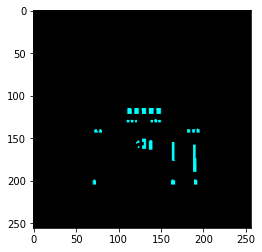

In [77]:
plt.imshow(Y[0])

In [79]:
os.listdir(root)

['README.md',
 'parse_database.py',
 'images',
 '.git',
 'gt_edge',
 'files.txt',
 'gt_label',
 '.gitignore',
 'DATASET SPLIT.csv']

In [83]:
# !sudo mkdir TMBuD/wind_segm

In [86]:
segm = 'TMBuD/wind_segm'
os.chdir(segm)
for idx, image in enumerate(df_windows):
  cv2.imwrite(f'{idx}.png', image)

In [61]:
cv2.imwrite(filename, img)

6

In [ ]:
for i in range(1, 7):
  img = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  images.append(img)
  img = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  lesions.append(img)

In [15]:
! pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ece6baf88ab1ca6178429f903cbdbbf2189ef1f8c74722e9baed3d8a18d1388c
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=c351cfe6de8f445d61649f1636c85ae809528a9be72133d3b9236620703f35df
  Stored in directory: /root/.cache/pip/w

In [20]:
# image = deepcopy(lesions[0])
# imgs = [lesions[0]]
# shape = image.shape
# # print(image.shape, shape[0])
# for row in range(shape[0]-1):
#   for col in range(shape[1]-1):
#     cell = image[row][col]
#     if all(cell == sky):
#       image[row][col] = background
#     if all(cell == vegetation):
#       image[row][col] = background
#     if all(cell == ground):
#       image[row][col] = background
#     if all(cell == noise):
#       image[row][col] = background
#     if all(cell == door):
#       image[row][col] = background

In [16]:


BACKBONE = 'resnet34'

IMAGE_HEIGHT_ORIG = 1024
IMAGE_WIDTH_ORIG = 1024
IMAGE_CHANNELS_ORIG = 3

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_CHANNELS = 3

BATCH_SIZE = 8

SAMPLE_SIZE = 15

NUM_EPOCHS = 30

THRESHOLD = 0.7

LRATE = 0.0001

# Check the number of available cpu cores.
# This variable is used to set the num workers in the data loader.
NUM_CORES = os.cpu_count()

NUM_CORES
import segmentation_models_pytorch as smp
# 3x512x512 RGB pre-processed image


# seg_model Output:
# .................

# Mask with values in range 0 to 1


ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
seg_model = smp.Unet(
    encoder_name=BACKBONE, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

print(seg_model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track